### Analyzing power-dependent OPO data

In [2]:
# Loading packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import scipy.io
import scipy.signal
import os
from datetime import date
import math
# %matplotlib notebook
import scipy.io
import seaborn as sns
sns.set()
sns.set_style("ticks")
sns.set_palette("dark")
c0 = 299792458
ħ = 1.054571817e-34
h = 6.626e-34
eps0 = 8.8541878128e-12

In [3]:
# Update plotting parameters
params = {'legend.fontsize': 'xx-large',         
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'font.sans-serif': "Arial",
          'font.family': "sans-serif",
          'figure.figsize': (6, 6),
         }
# sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update(params)
font = {'family' : 'sans-serif',
        'size'   : 14}
mpl.rc('font', **font)

In [5]:
# Load all data
folder_ids = [15, 5, 10, 51, 34, 48]

ang = np.load("data/Sweep N°15/Result.npy", allow_pickle = True)[0]
TotBits = np.zeros((len(folder_ids), len(ang)))
for ind in range(len(folder_ids)):
    TotBits[ind, :]=np.load("data/Sweep N°{0}/Result.npy".format(str(folder_ids[ind])),allow_pickle=True)[1]
    if np.where(TotBits[ind, :]==np.max(TotBits[ind, :]))[0][0] > len(ang)//2:
        TotBits[ind, :] = 1.0 - TotBits[ind, :]

Text(0, 0.5, 'Bit Mean (out of ~20 000 Bits)')

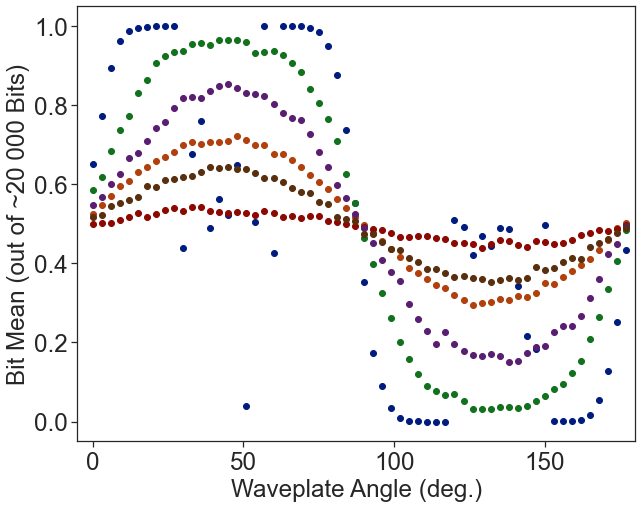

In [6]:
# Plotting raw data 
plt.figure(figsize = (10,8))
for ind in range(len(folder_ids)):
    plt.plot(ang, TotBits[ind, :], 'o')
plt.xlim([-5,180])
plt.xlabel("Waveplate Angle (deg.)")
plt.ylabel("Bit Mean (out of ~20 000 Bits)")

In [39]:
# Now need special treatment for Sweep N15 that saturates (all values are 1)
# Bit stream analysis takes raw data and turns it into a bit stream 
def BitStream(t,sig,mod, threshold = None, verbose = True):
    ndata=len(t)
    T=t[2]-t[1]
    Fs=1/T
    f=np.linspace(-Fs/2,Fs/2,num=ndata)
    fftvec = np.abs(np.fft.fftshift(np.fft.fft(sig-np.mean(sig))))
    ModFreq = abs(f[np.argmax(fftvec)])
    MinPeakDistance0 = int(1/ModFreq/T)
    MinPeakDistance = 0.75*MinPeakDistance0
    filter_order = 5
    if int(MinPeakDistance/10)%2==0:
        window_length = max(int(MinPeakDistance/10) +1, filter_order+2)
    else:
        window_length = max(int(MinPeakDistance/10), filter_order+2)
    y=scipy.signal.savgol_filter(sig,window_length,filter_order)
    ymod=scipy.signal.savgol_filter(mod,window_length,filter_order)
    max_value = np.max(np.diff(ymod[int(ndata/10):9*int(ndata/10)]))
    min_value = np.min(np.diff(ymod[int(ndata/10):9*int(ndata/10)]))
    peak_prominence = 0.4
    mod_up_t = scipy.signal.find_peaks(np.diff(ymod), height=peak_prominence * max_value, distance=MinPeakDistance)[0]
    mod_down_t = scipy.signal.find_peaks(np.diff(-ymod), height=-peak_prominence * min_value, distance=MinPeakDistance)[0]
    offset = int(np.mean(np.diff(mod_up_t))/10);
    if mod_up_t[0] > mod_down_t[0]:
        order = 1
    else:
        order = 0
    mm,modu,modu_std,xx=[0 for k in range(min(len(mod_up_t), len(mod_down_t))-1)],[0 for k in range(min(len(mod_up_t), len(mod_down_t))-1)],[0 for k in range(min(len(mod_up_t), len(mod_down_t))-1)],[0 for k in range(min(len(mod_up_t), len(mod_down_t))-1)] 
    for i in range(min(len(mod_up_t), len(mod_down_t))-1):
        if mod_up_t[i] < mod_down_t[i+order]:
            mm[i] = np.mean(y[mod_up_t[i]+offset:mod_down_t[i+order]-offset])
            modu[i] = np.mean(mod[mod_up_t[i]:mod_down_t[i+order]])
            modu_std[i] = np.std(mod[mod_up_t[i]:mod_down_t[i+order]])       
            xx[i] = t[int((mod_up_t[i]+mod_down_t[i+order])/2)]
    
    moving_mean_flag=False
    if not(moving_mean_flag):
        if threshold == None:
            threshold = [(min(mm)+max(mm))/2]*len(mm)
    else:
        np.convolve([1,2,3,4,5,6,7,8,9], np.ones(20)/20, mode='valid')
        threshold = movmean(mm, 20)
    low,high,mm0,xx0,mm1,xx1=[],[],[],[],[],[]
    if np.shape(threshold) == ():
        threshold = [threshold]*len(mm)
    for k in range(len(mm)):
        if mm[k]<threshold[k]:
            low.append(k)
            mm0.append(mm[k])
            xx0.append(xx[k])
        if mm[k]>threshold[k]:
            high.append(k)
            mm1.append(mm[k])
            xx1.append(xx[k])
            
    bit_stream = np.in1d(np.sort(low+high),high)
    nbits = len(bit_stream)
    mean_bit = np.mean(bit_stream)
    bit_flip_prob = np.mean(abs(np.diff(bit_stream)))
    test_pass = abs(mean_bit-0.5)<1/np.sqrt(nbits)
    if verbose:
        print('Extracted repetition rate = '+ str(1/(t[MinPeakDistance0]-t[1]))+'Hz \n')    
        print('Number of Bits %s \n' %nbits)
        print('Bit Mean %s \n' %mean_bit)
        print('Bit Flip Probability %s \n' %bit_flip_prob)
    return(mean_bit, threshold, xx0, mm0, xx1, mm1, bit_stream)

In [8]:
ind0 = 0 # index of saturated data 
[t,y,ymod]=np.load('data/Sweep N°15/Data_at_angle_0.npy', allow_pickle=True)
_, threshold, _, _, _, _, _ = BitStream(t,y,ymod); # manually setting threshold for saturated data 

for (a, aind) in zip(ang, range(len(ang))):
    [t,y,ymod]=np.load('data/Sweep N°15/Data_at_angle_{0}.npy'.format(int(a)), allow_pickle=True)
    mean_bit, _, _, _, _, _, _ = BitStream(t,y,ymod, threshold = threshold);
    TotBits[ind0, aind] = mean_bit

Extracted repetition rate = 10416.666583196777Hz 

Number of Bits 19999 

Bit Mean 0.6526326316315816 

Bit Flip Probability 0.45094509450945097 

Extracted repetition rate = 10416.666583196777Hz 

Number of Bits 19999 

Bit Mean 0.6526326316315816 

Bit Flip Probability 0.45094509450945097 

Extracted repetition rate = 10869.56442685815Hz 

Number of Bits 19999 

Bit Mean 0.7735386769338467 

Bit Flip Probability 0.3397839783978398 

Extracted repetition rate = 10869.56442685815Hz 

Number of Bits 19999 

Bit Mean 0.8935446772338617 

Bit Flip Probability 0.18876887688768876 

Extracted repetition rate = 10416.666583196777Hz 

Number of Bits 19999 

Bit Mean 0.9614480724036202 

Bit Flip Probability 0.07280728072807281 

Extracted repetition rate = 10869.56442685815Hz 

Number of Bits 19999 

Bit Mean 0.9870993549677484 

Bit Flip Probability 0.0251025102510251 

Extracted repetition rate = 10416.666583196777Hz 

Number of Bits 19999 

Bit Mean 0.9965998299914995 

Bit Flip Probabilit

Extracted repetition rate = 10416.666583196777Hz 

Number of Bits 19999 

Bit Mean 0.4326716335816791 

Bit Flip Probability 0.47759775977597757 



Text(0, 0.5, 'Bit Mean (out of ~20 000 Bits)')

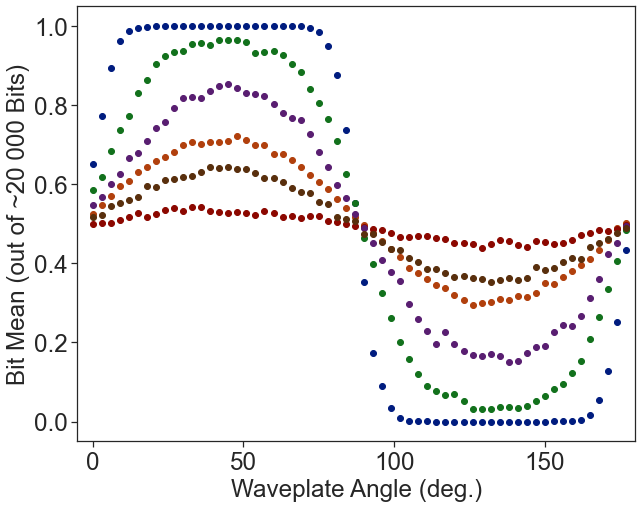

In [40]:
# Plotting data after saturation correction 
plt.figure(figsize = (10,8))
for ind in range(len(folder_ids)):
    plt.plot(ang, TotBits[ind, :], 'o')
plt.xlim([-5,180])
plt.xlabel("Waveplate Angle (deg.)")
plt.ylabel("Bit Mean (out of ~20 000 Bits)")

In [41]:
# A few useful functions
def fitting(x, b, phi):
    ang=2*np.pi*x/360+phi
    exp_arg = np.cos(2*ang)*b
    res = erf(exp_arg, 2.)
    return(res)

def sigmoid(x, b):
    exp_arg = 0.5*x*b
    return np.exp(exp_arg)/(np.exp(exp_arg)+np.exp(-exp_arg))

def erf(x, b):
    return (scipy.special.erf(x*b)+1)/2.

def logit(x):
    # Inverse of sigmoid function    
    return np.log(x/(1-x))

In [42]:
aarg = np.zeros((len(folder_ids),2))
pcov = np.zeros((len(folder_ids),2,2))
err_b = np.zeros((len(folder_ids),))
for ind in range(len(folder_ids)):
    aarg[ind, :], pcov[ind,:,:] = scipy.optimize.curve_fit(fitting, ang, TotBits[ind,:], p0=[-5,0])
    err_b[ind] = np.sqrt(np.diag(pcov[ind,:,:]))[0]

In [43]:
fit = np.zeros((len(folder_ids), len(ang)))
fit_up = np.zeros((len(folder_ids), len(ang)))
fit_lo = np.zeros((len(folder_ids), len(ang)))
for ind in range(len(folder_ids)):
    fit[ind,:]=[fitting(x, aarg[ind, 0], aarg[ind, 1]) for x in ang]
    fit_up[ind,:]=[fitting(x, aarg[ind, 0]-err_b[ind], aarg[ind, 1]) for x in ang]
    fit_lo[ind,:]=[fitting(x, aarg[ind, 0]+err_b[ind], aarg[ind, 1]) for x in ang]

In [44]:
order = np.argsort(np.abs(aarg[:,0]))
print("Fitting parameters = {0}".format(np.abs(aarg[order,0])))
print("Max / Min = {0}".format(np.max(np.abs(aarg[order,0]))/np.min(np.abs(aarg[order,0]))))

Fitting parameters = [0.03872358 0.12678226 0.1909717  0.35225586 0.6427516  1.69368944]
Max / Min = 43.73793581985436


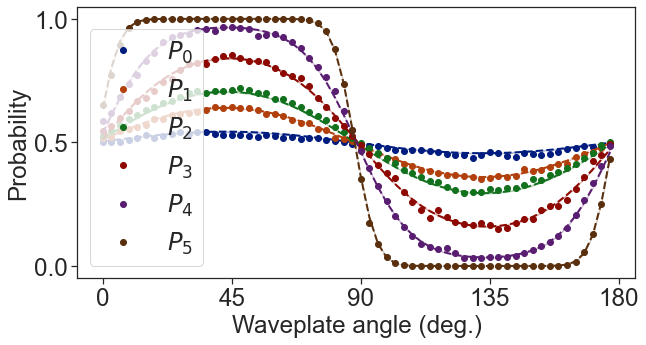

In [45]:
plt.figure(figsize = (10,5))
for (ind, oind) in zip(order, range(len(order))):
    p = plt.plot(ang, TotBits[ind, :], 'o', label = '$P_{0}$'.format(oind))
    plt.plot(ang, fit[ind, :], '--', linewidth = 2, color = p[0].get_color())
    plt.fill_between(ang, fit_up[ind, :], fit_lo[ind, :], color = p[0].get_color(), alpha = 0.2)

plt.xlabel("Waveplate angle (deg.)")
plt.ylabel("Probability")
plt.xticks([0,45,90,135,180])
plt.yticks([0,0.5,1.0])
plt.legend()

# Experimental power estimates

### Optical path of the bias field
- Input power was measured ~ 110-120 mW
- Two flat mirrors : not measured
- Beam splitter 1 (BS1): dividing LO/bias
- Discrete ND (NDD): baseline attenuation from reflection, otherwise variable 
- Waveplate + polarizer 1 (WP+POL1): variable
- Waveplate + polarizer 2 (WP+POL2): constant
- Pinhole 600 microns diameter (PIN) : constant
- Another 5 flat mirrors : constant
- Continuous ND (NDC) : constant
- Beam splitter 2 (BS2): constant
- Another 2-3 flat mirrors 
- In coupling mirror (IM): constant

### Measured sweeps
- folder_ids = [15, 5, 10, 51, 34, 48] 
12/06/2022
- Waveplate angle: 179 // ND: 2.0 // \Sweep N°5
- Waveplate angle: 176 // ND: 2.0 // \Sweep N°10
- Waveplate angle: 176  // ND: 0.04 // \Sweep N°15
- Waveplate angle: 178  // ND: 1.0 // \Sweep N°34
- Waveplate angle: 180 // ND: 2.0 // \Sweep N°48 
- Waveplate angle: 178 // ND: 3.0 // \Sweep N°51

In [46]:
# Input power
in_power = 116e-3 # W \pm 4 mW

# Calculates base attenuation (common to all sweep data)
base_att = 1. 
base_att *= 0.5 # BS1
base_att *= 0.9 # NDD (baseline only) [Guess-timated]
base_att *= 1. # WP2 [Assumed, given we did not measure it separately]
base_att *= 62e-3/16.94 # PIN + POL2 
base_att *= 2.7/(900/0.9) # NDC
base_att *= 0.5 # BS2
base_att *= (83e-3)/9.04 # IM 
base_att *= (0.98)**7. # all mirrors (estimated from https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=903&pn=PF10-03-P01)

base_att_dB = 10*np.log10(1/base_att)
print("Baseline attenuation = {0} dB".format(base_att_dB))

Baseline attenuation = 77.5148324247791 dB


In [47]:
# Calculates variable attenuation (sweep-specific)
# List of measurements of the form [sweep number, WP1 angle, ND optical density]
# [15, 5, 10, 51, 34, 48]
meas_list = np.array([[15,176,0.04], [5,179,2.0], [10,176,2.0], [51,178,3.0], [34,178,1.0], [48,180,2.0]])

Text(0, 0.5, 'Attenuation (%)')

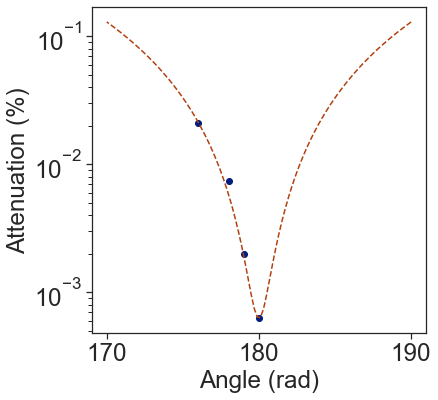

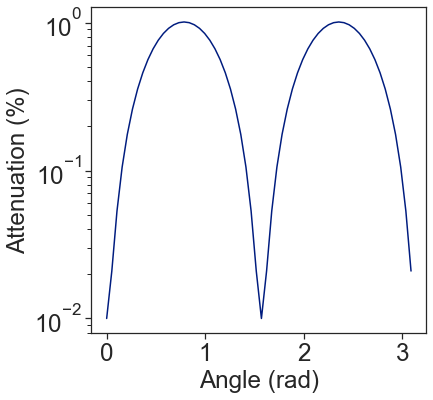

In [48]:
# Determining waveplate attenuation function
WP_att_vec = np.array([0.5, 1.6, 5.9, 16.8, 800])/800.
WP_ang_vec = np.array([180, 179, 178, 176, 135])*np.pi/180.

def WP_att_fit(angle, α):
    return α*np.sin(angle)**2. + WP_att_vec[0]
#     return α*(angle-np.pi)**2. + min_value

def WP_att_rotating(angle):
    ''' Attenuation coefficient for the rotating waveplate '''
    max_att = 1e-2
    return np.sin(2*angle)**2. + max_att

def phase_field(angle):
    ''' Modulation imparted by waveplate on field at a given angle '''
    ''' Resulting field is E_in * phase_field(angle) '''    
    max_att = 1e-3
    return np.sin(2*angle) + max_att

aarg, pcov = scipy.optimize.curve_fit(WP_att_fit, WP_ang_vec[:-1], WP_att_vec[:-1], p0=[1.])
                               
    
angs_vec = np.linspace(190,170,100)*np.pi/180.

plt.figure()
plt.semilogy(WP_ang_vec[:-1]*180./np.pi, WP_att_vec[:-1], 'o')
plt.semilogy(angs_vec*180./np.pi, WP_att_fit(angs_vec, aarg[0]), '--')
plt.xlabel("Angle (rad)")
plt.ylabel("Attenuation (%)")


plt.figure()
plt.semilogy(ang*np.pi/180., WP_att_rotating(ang*np.pi/180.))
plt.xlabel("Angle (rad)")
plt.ylabel("Attenuation (%)")

In [23]:
def WP_att(angle):
    # Calculates NDD attenuation based on measured data and fit 
    ang_ind = np.where(np.min(np.abs(angle-angs_vec))==np.abs(angle-angs_vec))[0][0]
    return WP_att_fit(angs_vec[ang_ind], aarg[0])

def NDD_att(OD):
    # Calculates variable attenuation from discrete ND filter given OD segment
    if OD == 3.0:
        return 0.6/83.
    if OD == 2.0:
        return 2.3/83.
    if OD == 1.0:
        return 10.7/83.
    if OD == 0.8:
        return 15/83.
    if OD == 0.6:
        return 22.8/83.
    if OD == 0.4:
        return 36.9/83.
    if OD == 0.2:
        return 56/83.
    if OD == 0.04:
        return 83./83.

In [24]:
n_pulses_per_sec = 80e6 # modulation rate
pulse_duration = 190e-15 #fwhm (s)
refind = 2.2 # approximate -- value from refractiveindex.info
beam_area = np.pi*(10e-6)**2. # in m^2

n_photons_per_sec_vec, n_photons_per_pulse_vec, mean_power_sweep_vec, n_photons_per_pulse_m_vec, n_photons_per_pulse_p_vec, peak_E_vec, peak_E_m_vec, peak_E_p_vec = [],[],[],[],[],[],[],[]

λ0 = 1544e-9
ω0 = 2*np.pi*c0/λ0
for meas in meas_list:
    [sweep_number, WP_ang, OD] = meas
    var_att = WP_att(WP_ang*np.pi/180.)*NDD_att(OD)
    var_att_dB = 10*np.log10(1/var_att)
    tot_att_dB = var_att_dB + base_att_dB
    
    WP_ang_err = 1.0 # in deg.
    # Calculates error bars from precision on WP angle 
    var_att_p = np.min([WP_att((WP_ang+WP_ang_err)*np.pi/180.)*NDD_att(OD), WP_att((WP_ang-WP_ang_err)*np.pi/180.)*NDD_att(OD)])
    var_att_m = np.max([WP_att((WP_ang+WP_ang_err)*np.pi/180.)*NDD_att(OD), WP_att((WP_ang-WP_ang_err)*np.pi/180.)*NDD_att(OD)])
    tot_att_p_dB = 10*np.log10(1/var_att_p) + base_att_dB  
    tot_att_m_dB = 10*np.log10(1/var_att_m) + base_att_dB   
    
    mean_power_sweep = in_power*var_att*base_att
    n_photons_per_sec = mean_power_sweep/(ħ*ω0) # number of photons per second (average)
    n_photons_per_pulse = n_photons_per_sec/n_pulses_per_sec # number of photons per pulse in train 
    n_photons_per_pulse_p = in_power*var_att_p*base_att/(ħ*ω0)/n_pulses_per_sec
    n_photons_per_pulse_m = in_power*var_att_m*base_att/(ħ*ω0)/n_pulses_per_sec
    
    # Estimate peak E-field
    peak_power = mean_power_sweep/n_pulses_per_sec/pulse_duration
    peak_E = np.sqrt(peak_power/eps0/c0/refind/beam_area*2.)
    peak_power_m = in_power*var_att_m*base_att/n_pulses_per_sec/pulse_duration
    peak_E_m = np.sqrt(peak_power_m/eps0/c0/refind/beam_area*2.)    
    peak_power_p = in_power*var_att_p*base_att/n_pulses_per_sec/pulse_duration
    peak_E_p = np.sqrt(peak_power_p/eps0/c0/refind/beam_area*2.)        

    mean_power_sweep_vec.append(in_power*var_att*base_att)
    n_photons_per_sec_vec.append(n_photons_per_sec)
    n_photons_per_pulse_vec.append(n_photons_per_pulse)
    n_photons_per_pulse_p_vec.append(n_photons_per_pulse_p)
    n_photons_per_pulse_m_vec.append(n_photons_per_pulse_m)    
    peak_E_vec.append(peak_E)
    peak_E_m_vec.append(peak_E_m)
    peak_E_p_vec.append(peak_E_p)    
    
    print("Measurement Sweep N°{0}, ang = {1}, OD = {2} total attenuation = {3} dB (+\- {4}\{5})".format(int(sweep_number), WP_ang, OD, tot_att_dB, tot_att_p_dB, tot_att_m_dB))
    print("Mean power to crystal = {0} pW".format(mean_power_sweep*1e12))
    print("Peak field to crystal = {0} kV/m".format(peak_E*1e-3))    
    print("Number of photons per pulse = {0} (+\-: {1} / {2})\n".format(n_photons_per_pulse, n_photons_per_pulse_p, n_photons_per_pulse_m))
    
mean_power_sweep_vec = np.array(mean_power_sweep_vec)
n_photons_per_sec_vec = np.array(n_photons_per_sec_vec)
n_photons_per_pulse_vec = np.array(n_photons_per_pulse_vec)
n_photons_per_pulse_p_vec = np.array(n_photons_per_pulse_p_vec)
n_photons_per_pulse_m_vec = np.array(n_photons_per_pulse_m_vec)

Measurement Sweep N°15, ang = 176.0, OD = 0.04 total attenuation = 94.34057259270337 dB (+\- 96.80660220317844\92.40999313362437)
Mean power to crystal = 42.69733116986837 pW
Peak field to crystal = 1.7499376522334193 kV/m
Number of photons per pulse = 4.1484065076211865 (+\-: 2.351139218315056 / 6.470521025862442)

Measurement Sweep N°5, ang = 179.0, OD = 2.0 total attenuation = 120.78541521583563 dB (+\- 125.03832386302886\115.75481888251876)
Mean power to crystal = 0.09680916352600598 pW
Peak field to crystal = 0.08332598276284368 kV/m
Number of photons per pulse = 0.00940582825589014 (+\-: 0.0035326952943444804 / 0.029954127765681852)

Measurement Sweep N°10, ang = 176.0, OD = 2.0 total attenuation = 109.91407515628818 dB (+\- 112.38010476676325\107.98349569720918)
Mean power to crystal = 1.1831790565144245 pW
Peak field to crystal = 0.29130467033136226 kV/m
Number of photons per pulse = 0.1149558429822738 (+\-: 0.06515205062800757 / 0.1793035946925737)

Measurement Sweep N°51, ang

Experiment Power Max / Min = 34.26790573135388
Experiment Power Max / Min = 15.810319654719088
Experiment Power Max / Min = 51.35224053521888


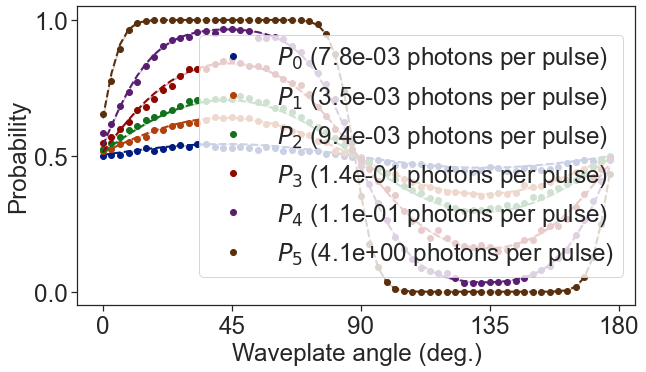

In [25]:
plt.figure(figsize = (10,5.5))
for (ind, oind) in zip(order, range(len(order))):
    p = plt.plot(ang, TotBits[ind, :], 'o', label = '$P_{}$ ({:.1e} photons per pulse)'.format(oind, n_photons_per_pulse_vec[ind]))
    plt.plot(ang, fit[ind, :], '--', linewidth = 2, color = p[0].get_color())
    plt.fill_between(ang, fit_up[ind, :], fit_lo[ind, :], color = p[0].get_color(), alpha = 0.2)

plt.xlabel("Waveplate angle (deg.)")
plt.ylabel("Probability")
plt.xticks([0,45,90,135,180])
plt.yticks([0,0.5,1.0])
plt.legend()

print("Experiment Power Max / Min = {0}".format(np.sqrt(np.max(n_photons_per_pulse_vec)/np.min(n_photons_per_pulse_vec))))
print("Experiment Power Max / Min = {0}".format(np.sqrt(np.max(n_photons_per_pulse_p_vec)/np.min(n_photons_per_pulse_m_vec))))
print("Experiment Power Max / Min = {0}".format(np.sqrt(np.max(n_photons_per_pulse_m_vec)/np.min(n_photons_per_pulse_p_vec))))


# Simple statistical model + plotting probs vs. power (photons per pulse)

In [26]:
L_mode = pulse_duration*c0 # Rayleigh range 

peak_E_stat_vec = np.logspace(0, 4, 100) # in V/m
n_photon_stat_vec = eps0*c0*refind/2.*beam_area*peak_E_stat_vec**2.*pulse_duration/(ħ*ω0) # Corresponding number of photons per pulse
Nsamples = 10000
probs = np.zeros_like(peak_E_stat_vec)
probs_m = np.zeros_like(peak_E_stat_vec)
probs_p = np.zeros_like(peak_E_stat_vec)
fluct_amp = np.sqrt(ħ*ω0/(2*eps0*refind*beam_area*L_mode))

for (pp, pp_ind) in zip(peak_E_stat_vec, range(len(peak_E_stat_vec))):
    draw_ph = np.sqrt(2)*peak_E_stat_vec[pp_ind] # Assumes that part is deterministic 
    fluctuations = np.random.normal(loc = 0., scale = fluct_amp, size = Nsamples)
    vals = np.sign(draw_ph + fluctuations)
    probs[pp_ind] = np.sum(vals==1)/Nsamples

In [27]:
# Analytical model
analytical_probs = erf(np.sqrt(n_photon_stat_vec), 2.)
analytical_probs_m = erf(np.sqrt(n_photon_stat_vec*10), 2.)
analytical_probs_p = erf(np.sqrt(n_photon_stat_vec*0.1), 2.)

(0.45, 1.05)

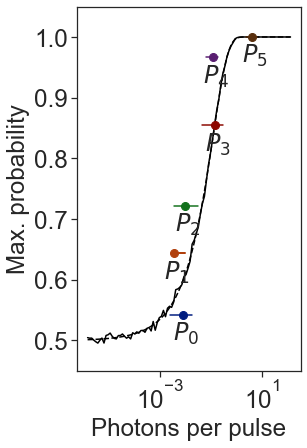

In [29]:
fig = plt.figure(figsize = (4,6.7))
ax = fig.add_subplot(1, 1, 1)
plt.plot(n_photon_stat_vec, probs, color = 'black')
plt.plot(n_photon_stat_vec, analytical_probs, '--', color = 'black')

for (ind, oind) in zip(order, range(len(order))):
    p = plt.plot([n_photons_per_pulse_m_vec[ind], n_photons_per_pulse_vec[ind], n_photons_per_pulse_p_vec[ind]], np.ones((3,1))*np.max(np.abs(TotBits[ind, :])))
    plt.plot(n_photons_per_pulse_vec[ind], np.max(np.abs(TotBits[ind, :])), 'o', color = p[0].get_color(), markersize = 8.0)
    ax.annotate('$P_{}$'.format(oind), (n_photons_per_pulse_vec[ind]*0.4, -0.042+np.max(np.abs(TotBits[ind, :]))), fontsize = 24)

plt.xlabel("Photons per pulse")
plt.ylabel("Max. probability")
# plt.colorbar()
ax.set_xscale('log')
plt.ylim(0.45,1.05)

/var/folders/ns/71kc1s_x5tzdqvjj2gv0cw300000gn/T/ipykernel_29126/1050119416.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nph = np.array(nph)


3.53269529434448e-05
4.14456425503589
Max/Min number of photons = 3.53269529434448e-05/4.14456425503589


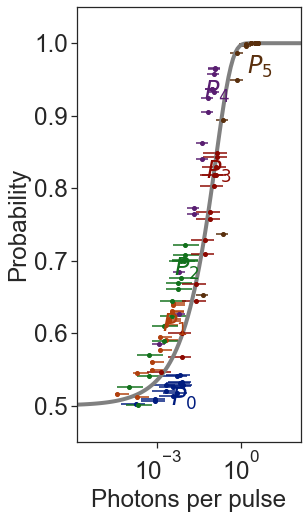

In [30]:
''' Plotting all data instead of just max value'''

fig = plt.figure(figsize = (4,8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(n_photon_stat_vec, analytical_probs, color = 'grey',  linewidth = 4.)

nph = []
for (ind, oind) in zip(order, range(len(order))):
    nph_err_m, nph_mean, nph_err_p = np.sort([n_photons_per_pulse_m_vec[ind], n_photons_per_pulse_vec[ind], n_photons_per_pulse_p_vec[ind]])
    n_photons_per_pulse_err = np.abs(np.vstack(((nph_mean-nph_err_m)*WP_att_rotating(ang*np.pi/180.), (nph_err_p-nph_mean)*WP_att_rotating(ang*np.pi/180.))))
    if oind == 1:
        nph_err_m, nph_mean, nph_err_p = [n_photons_per_pulse_vec[ind],n_photons_per_pulse_vec[ind], n_photons_per_pulse_p_vec[ind]]
        n_photons_per_pulse_err = np.abs(np.vstack((nph_mean*(WP_att_rotating((ang+WP_ang_err)*np.pi/180.)-WP_att_rotating((ang)*np.pi/180.)), (nph_err_p-nph_mean)*WP_att_rotating(ang*np.pi/180.))))        
   
    indices_to_plot = np.where(TotBits[ind, :] > 0.5)[0][::2]
    p = plt.errorbar(n_photons_per_pulse_vec[ind]*WP_att_rotating(ang[indices_to_plot]*np.pi/180.), np.abs(TotBits[ind, indices_to_plot]), xerr = n_photons_per_pulse_err[:, indices_to_plot], marker = 'o', markersize = 4.0, linestyle = '')
    inp=n_photons_per_pulse_vec[ind]*WP_att_rotating(ang[indices_to_plot]*np.pi/180.)
    nph.append([x for x in inp])
    ax.annotate('$P_{}$'.format(oind), (n_photons_per_pulse_vec[ind]*0.4, -0.042+np.max(np.abs(TotBits[ind, :]))), fontsize = 24, color = p[0].get_color())

nph = np.array(nph)
print(np.min(np.min(nph)))
print(np.max(np.max(nph)))
print("Max/Min number of photons = {0}/{1}".format(np.min(np.min(nph)), np.max(np.max(nph))))

def ntoE(n):
    # Normalized to vacuum fluctuations 
    return np.sqrt(n/(eps0*c0*refind*beam_area/2.*pulse_duration/(ħ*ω0)))/fluct_amp

def Eton(E):
    return eps0*c0/2.*refind*beam_area*E**2.*pulse_duration/(ħ*ω0)

plt.xlabel("Photons per pulse")
plt.ylabel("Probability")
# plt.colorbar()
ax.set_xscale('log')
plt.xlim([np.min(n_photon_stat_vec), np.max(n_photon_stat_vec)])
plt.ylim(0.45,1.05)

# Bit streams for Figure

In [34]:
def PlotBitStream(sweep_number, ax_ind, pow_ind):
#     ax_ind = (ax_ind//2, np.mod(ax_ind, 2))
    ax_ind = (np.mod(ax_ind, 3), ax_ind//3)
    # Plots all bit streams together 
    max_t = 2850
    print("Plotting data from Sweep N°{0}".format(str(sweep_number)))
    test_bits = np.load("data/Sweep N°{0}/Result.npy".format(str(sweep_number)),allow_pickle=True)[1]
    if np.where(test_bits == np.max(test_bits))[0][0] > len(ang)//2:
        signal = np.load("data/Sweep N°{0}/Data_at_angle_135.npy".format(str(sweep_number)),allow_pickle=True) 
    else:
        signal = np.load("data/Sweep N°{0}/Data_at_angle_45.npy".format(str(sweep_number)),allow_pickle=True) 
        
    indices = [int(n) for n in np.arange(max_t, 2*max_t)]
#     if sweep_number == folder_ids[-1]:
    if pow_ind == 0:
        signal_ref = np.load("data/Sweep N°{0}/Data_at_angle_0.npy".format(str(sweep_number)),allow_pickle=True) 
        _, threshold, _, mm0, _, _, _ = BitStream(signal_ref[0,indices], signal_ref[1,indices], signal_ref[2,indices])
        threshold_save = np.mean(mm0/np.max(signal_ref[1, indices])+np.min(signal_ref[1, indices]))
        _, _, xx0, mm0, xx1, mm1, _ = BitStream(signal[0, indices], signal[1, indices], signal[2, indices], threshold = threshold)    
    else:
        _, _, xx0, mm0, xx1, mm1, _ = BitStream(signal[0, indices], signal[1, indices], signal[2, indices])            
    xx0 = np.array(xx0)
    xx1 = np.array(xx1)
    xx0 = (xx0)*1e4
    xx1 = (xx1)*1e4
    signal_y = signal[1, indices]/np.max(signal[1, indices])
    signal_t = (signal[0, indices])*1e4 # In cycle number (assumes 10kHz rep rate)
#     signal_t = signal[0, indices]

    mm0 /= np.max(signal[1, indices])
    mm1 /= np.max(signal[1, indices])
    
    mm0 += np.min(signal[1, indices])
    mm1 += np.min(signal[1, indices])
    
    Vhigh = np.mean(mm1) 
    if mm0.size>0:
        Vlow = np.mean(mm0)
    else:
        Vlow = threshold_save        

    # Plotting parameters 
    plot_width = 1.0
    xshift = 120
    alpha_bar = 0.5
    
    ax[ax_ind].set_ylim([Vlow*0.85, Vhigh*1.1])
    ax[ax_ind].set_xlim([0, 100])
    ax[ax_ind].set_xticks([])
    ax[ax_ind].set_yticks([Vlow, Vhigh]) 
    ax[ax_ind].tick_params(labelleft=False)    
    ax[ax_ind].plot(signal_t-xshift, signal_y, color = 'black', linewidth = 0.5, label = '$P_{0}, folder = {1}$'.format(oind, ind))   
    if pow_ind == 0: # if max power plot saturated data differently
#         ax[ax_ind].bar(xx0-xshift, mm0, width = plot_width, alpha = alpha_bar, color = 'blue')
#         ax[ax_ind].bar(xx1-xshift, mm1, width = plot_width, alpha = alpha_bar, color = 'blue')
        ax[ax_ind].set_ylim([Vlow*0.9, Vhigh*1.1])
        ax[ax_ind].bar(xx0-xshift, 1.2, width = plot_width, alpha = alpha_bar, color = 'blue', linewidth = 0.)
        ax[ax_ind].bar(xx1-xshift, 1.2, width = plot_width, alpha = alpha_bar, color = 'blue', linewidth = 0.)
    else:
#         ax[ax_ind].bar(xx0-xshift, mm0, width = plot_width, alpha = alpha_bar, color = 'red')
#         ax[ax_ind].bar(xx1-xshift, mm1, width = plot_width, alpha = alpha_bar, color = 'blue')
        ax[ax_ind].bar(xx0-xshift, 1.2, width = plot_width, alpha = alpha_bar, color = 'red', linewidth = 0.)
        ax[ax_ind].bar(xx1-xshift, 1.2, width = plot_width, alpha = alpha_bar, color = 'blue', linewidth = 0.)
#     ax[ax_ind].legend()

Plotting data from Sweep N°51
Extracted repetition rate = 10416.68840403962Hz 

Number of Bits 113 

Bit Mean 0.5929203539823009 

Bit Flip Probability 0.5357142857142857 

Plotting data from Sweep N°48
Extracted repetition rate = 10416.68840403962Hz 

Number of Bits 112 

Bit Mean 0.7053571428571429 

Bit Flip Probability 0.3783783783783784 

Plotting data from Sweep N°5
Extracted repetition rate = 10416.68840403962Hz 

Number of Bits 112 

Bit Mean 0.7142857142857143 

Bit Flip Probability 0.3963963963963964 

Plotting data from Sweep N°34
Extracted repetition rate = 10416.68840403962Hz 

Number of Bits 113 

Bit Mean 0.8230088495575221 

Bit Flip Probability 0.30357142857142855 

Plotting data from Sweep N°10
Extracted repetition rate = 10869.592484612893Hz 

Number of Bits 112 

Bit Mean 0.9642857142857143 

Bit Flip Probability 0.07207207207207207 

Plotting data from Sweep N°15
Extracted repetition rate = 10416.68840403962Hz 

Number of Bits 113 

Bit Mean 0.6460176991150443 

Bi

Text(0.5, 0, 'Bit number')

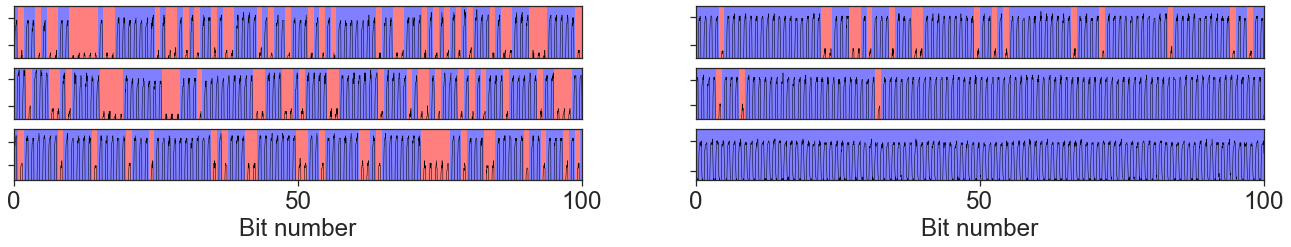

In [35]:
fig, ax = plt.subplots(3, 2, figsize = (22.4,3.2))
for (ind, oind) in zip(order, range(len(order))):
    PlotBitStream(folder_ids[ind], oind, ind)
ax[2,0].set_xticks([0, 50,100])    
ax[2,1].set_xticks([0, 50,100])    
ax[2,0].set_xlabel("Bit number")
ax[2,1].set_xlabel("Bit number")

# Reconstructing EM ground state probability $\Phi_0(E)$

Text(0, 0.5, '$|\\Psi_0(E)|^2$ density (m/V)')

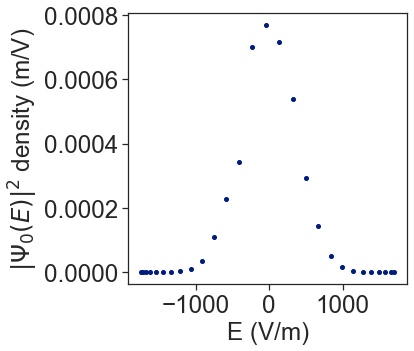

In [36]:
ind = 0
angles_to_plot = np.where((45<ang) & (ang<135))
ang_err = 3.8*np.pi/180
E_to_fit = peak_E_vec[ind]*phase_field(ang[angles_to_plot]*np.pi/180.+ang_err)

# Finite difference nearest neighbor 
density = np.transpose(np.diff(TotBits[ind, angles_to_plot][0]))/np.diff(E_to_fit)
density = density / np.sqrt(2)
E_to_fit = E_to_fit[:-1]

plt.figure(figsize = (5,5))
p = plt.plot(E_to_fit, density, marker = 'o', markersize = 4.0, linestyle = '')
plt.xlabel('E (V/m)')
plt.ylabel('$|\Psi_0(E)|^2$ density (m/V)')

In [37]:
def gauss_fit(x, μ, fwhm, a):
    σ = fwhm / (2*np.sqrt(2*np.log(2)))
    return a*np.exp(-(x-μ)**2./2./σ**2.)

aarg, pcov = scipy.optimize.curve_fit(gauss_fit, E_to_fit.flatten(), density.flatten(), p0 = [0, 600, 1.])
err = np.sqrt(np.diag(pcov))

Gaussian fit FWHM = 842.6470755705325 +/- 15.539422376880207
Gaussian fit σ = 357.8392656154995 +/- 6.598985094283913
Estimated Evac = 506.0611425830678 +/- 9.332374218234207
Theory Evac = 429.5877875107394


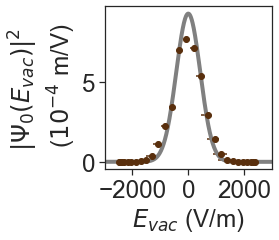

In [38]:
E_to_plot = np.linspace(-4000, 4000, 1000)
E_err = np.vstack(((peak_E_vec[ind]-peak_E_m_vec[ind])*phase_field(ang[angles_to_plot]*np.pi/180.+ang_err), (peak_E_p_vec[ind]-peak_E_vec[ind])*phase_field(ang[angles_to_plot]*np.pi/180.-ang_err)))[:,:-1]

vacuum_theory = np.exp(-E_to_plot**2./fluct_amp**2./2.)/(np.sqrt(2*np.pi)*fluct_amp)

plt.figure(figsize = (3,3))
p = plt.errorbar(E_to_fit*np.sqrt(2), density*1e4, xerr = E_err, marker = 'o', markersize = 6.0, linestyle = '', color = sns.color_palette('dark')[5])
# p = plt.plot(E_to_plot, gauss_fit(E_to_plot, *aarg)*1e4, '--', color = 'black', linewidth = 2.)
p = plt.plot(E_to_plot, vacuum_theory*1e4, color = 'grey', linewidth = 4.)
plt.xlabel('$E_{vac}$ (V/m)')
plt.ylabel('$|\Psi_0(E_{vac})|^2$ \n ($10^{-4}$ m/V)')
plt.xticks([-2000,0,2000])
plt.xlim([-3000,3000])

print("Gaussian fit FWHM = {0} +/- {1}".format(aarg[1],err[1]))
σ_est = aarg[1]/(2*np.sqrt(2*np.log(2)))
σ_est_err = err[1]/(2*np.sqrt(2*np.log(2)))
print("Gaussian fit σ = {0} +/- {1}".format(σ_est, σ_est_err))
print("Estimated Evac = {0} +/- {1}".format(σ_est*np.sqrt(2.), σ_est_err*np.sqrt(2.)))
print("Theory Evac = {0}".format(fluct_amp))